# Plan Mode Evaluation — Results Analysis

This notebook loads **scores.json** from the evaluation pipeline (e.g. `data/test_run/scores.json` or `data/run-30-tasks/scores.json`) and presents summary statistics, score distributions, and per-metric breakdowns.

**Score composition (0–100):**
- **Claim verification (40%)**: verified_and_unknown_claim_ratio 20%, logical_soundness 20%
- **Ground truth (40%)**: file_recall 10%, file_precision 10%, gt_judge 20%
- **Quality (20%)**: conciseness, precision, tone, formatting 5% each

## 1. Setup & load data

Either **upload** `scores.json` when prompted, or set `SCORES_PATH` below (e.g. after cloning the repo or mounting Drive). Works with 2 tasks (test_run) or 30 tasks (run-30-tasks).

In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", palette="muted")
%matplotlib inline

In [23]:
# Option A: Set path to scores.json (clone repo first in Colab, or use local path)
SCORES_PATH = "data/run-30-tasks/scores.json"  # or "data/run-30-tasks/scores.json" for full run; set None to upload in Colab

if SCORES_PATH and Path(SCORES_PATH).exists():
    path = SCORES_PATH
else:
    try:
        from google.colab import files
        uploaded = files.upload()
        path = list(uploaded.keys())[0] if uploaded else None
    except ImportError:
        path = None
    if path is None:
        raise FileNotFoundError("Set SCORES_PATH to your scores.json path or upload the file in Colab.")


with open(path) as f:
    scores_raw = json.load(f)

# Normalize to list of dicts if single object
if isinstance(scores_raw, dict):
    scores_raw = [scores_raw]

df = pd.DataFrame(scores_raw)
print(f"Loaded {len(df)} tasks.")
df.head()

Loaded 30 tasks.


,task_id,score,breakdown
0,task_001,33.15,"{'verified_and_unknown_claim_ratio': 0.0, 'unk..."
1,task_002,57.50,"{'verified_and_unknown_claim_ratio': 0.75, 'un..."
2,task_003,57.67,"{'verified_and_unknown_claim_ratio': 1.0, 'unk..."
3,task_004,60.00,"{'verified_and_unknown_claim_ratio': 0.75, 'un..."
4,task_005,55.00,"{'verified_and_unknown_claim_ratio': 0.75, 'un..."


In [24]:
# Expand breakdown into columns for analysis
breakdown_df = pd.json_normalize(df["breakdown"])
breakdown_df.index = df["task_id"]
df_scores = df[["task_id", "score"]].set_index("task_id")
df_full = df_scores.join(breakdown_df)
df_full.head(10)

,score,verified_and_unknown_claim_ratio,unknown_claim_ratio,logical_soundness,file_recall,file_precision,gt_judge,conciseness,precision,tone,formatting
task_id,,,,,,,,,,,
task_001,33.15,0.00,0.00,0.75,0.047619,0.017857,0.25,0.25,0.75,0.75,0.75
task_002,57.50,0.75,0.50,1.00,0.000000,0.000000,0.25,0.50,1.00,1.00,1.00
task_003,57.67,1.00,1.00,0.75,0.083333,0.058824,0.25,0.50,1.00,0.75,1.00
task_004,60.00,0.75,0.25,1.00,0.000000,0.000000,0.50,0.50,0.75,0.75,1.00
task_005,55.00,0.75,0.75,0.75,0.000000,0.000000,0.50,0.50,0.75,0.75,1.00
task_006,57.50,1.00,1.00,0.75,0.000000,0.000000,0.25,0.50,1.00,1.00,1.00
task_007,58.96,1.00,0.00,0.75,0.200000,0.071429,0.25,0.50,1.00,0.75,1.00
task_008,69.25,1.00,0.50,0.75,0.133333,0.666667,0.50,0.50,1.00,0.75,1.00
task_009,39.47,0.00,0.00,0.75,0.030769,0.666667,0.25,0.25,0.75,0.75,0.75


## 2. Summary statistics

In [25]:
summary = df["score"].agg(["count", "mean", "std", "min", "max", "median"])
summary.name = "Overall score (0–100)"
display(summary.to_frame())
print()
print("Per-metric means (0–1):")
display(breakdown_df.mean().to_frame(name="mean").round(3))

,Overall score (0–100)
count,30.000000
mean,60.243333
std,10.121601
min,33.150000
max,77.500000
median,61.080000



Per-metric means (0–1):


,mean
verified_and_unknown_claim_ratio,0.825
unknown_claim_ratio,0.617
logical_soundness,0.833
file_recall,0.152
file_precision,0.143
gt_judge,0.408
conciseness,0.492
precision,0.917
tone,0.817
formatting,0.967


## 3. Score distribution

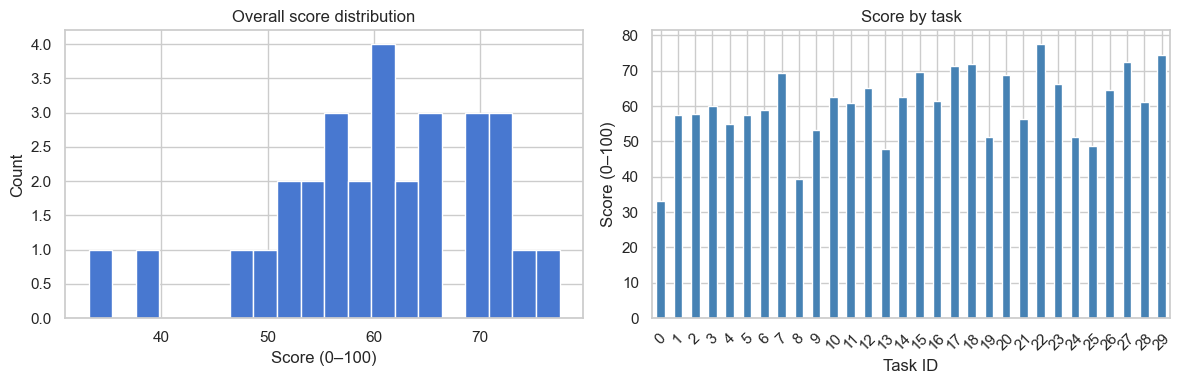

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df["score"], bins=min(20, max(5, len(df))), edgecolor="white")
axes[0].set_xlabel("Score (0–100)")
axes[0].set_ylabel("Count")
axes[0].set_title("Overall score distribution")

df["score"].plot(kind="bar", ax=axes[1], color="steelblue", edgecolor="white")
axes[1].set_xlabel("Task ID")
axes[1].set_ylabel("Score (0–100)")
axes[1].set_title("Score by task")
axes[1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

## 4. Metric breakdown

**Categories:**
- **Claim**: verified_and_unknown_claim_ratio, unknown_claim_ratio, logical_soundness
- **Ground truth**: file_recall, file_precision, gt_judge
- **Quality**: conciseness, precision, tone, formatting

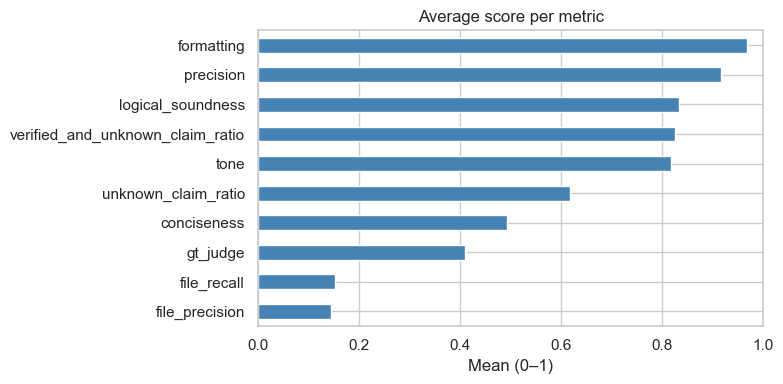

In [27]:
metrics = list(breakdown_df.columns)
means = breakdown_df[metrics].mean().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(8, max(4, len(metrics) * 0.35)))
means.plot(kind="barh", ax=ax, color="steelblue", edgecolor="white")
ax.set_xlabel("Mean (0–1)")
ax.set_title("Average score per metric")
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

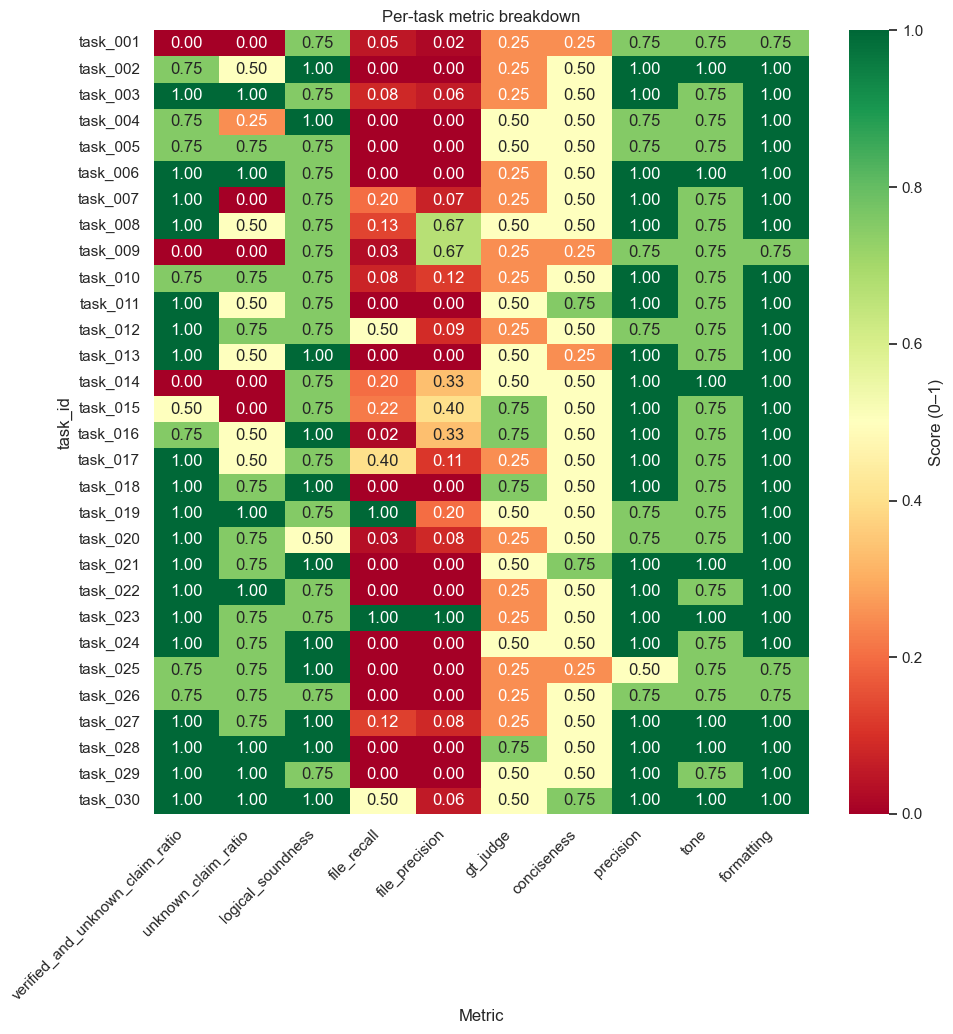

In [28]:
fig, ax = plt.subplots(figsize=(10, max(6, len(df) * 0.35)))
sns.heatmap(
    breakdown_df[metrics],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar_kws={"label": "Score (0–1)"},
)
ax.set_title("Per-task metric breakdown")
ax.set_xlabel("Metric")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 5. Full score table

Per-task overall score and all metric values (scrollable when you have 30 tasks).

In [29]:
display(df_full.round(3))

,score,verified_and_unknown_claim_ratio,unknown_claim_ratio,logical_soundness,file_recall,file_precision,gt_judge,conciseness,precision,tone,formatting
task_id,,,,,,,,,,,
task_001,33.15,0.00,0.00,0.75,0.048,0.018,0.25,0.25,0.75,0.75,0.75
task_002,57.50,0.75,0.50,1.00,0.000,0.000,0.25,0.50,1.00,1.00,1.00
task_003,57.67,1.00,1.00,0.75,0.083,0.059,0.25,0.50,1.00,0.75,1.00
task_004,60.00,0.75,0.25,1.00,0.000,0.000,0.50,0.50,0.75,0.75,1.00
task_005,55.00,0.75,0.75,0.75,0.000,0.000,0.50,0.50,0.75,0.75,1.00
task_006,57.50,1.00,1.00,0.75,0.000,0.000,0.25,0.50,1.00,1.00,1.00
task_007,58.96,1.00,0.00,0.75,0.200,0.071,0.25,0.50,1.00,0.75,1.00
task_008,69.25,1.00,0.50,0.75,0.133,0.667,0.50,0.50,1.00,0.75,1.00
task_009,39.47,0.00,0.00,0.75,0.031,0.667,0.25,0.25,0.75,0.75,0.75


## 6. Category-level averages

Average contribution by category (metric averages, not weighted by rubric).

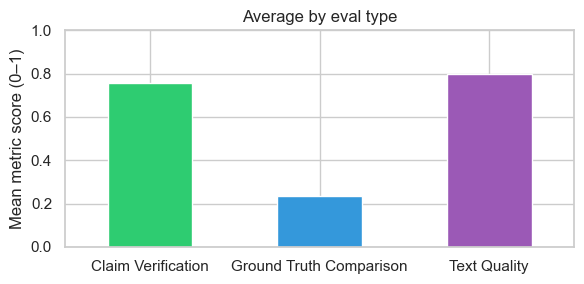

In [30]:
categories = {
    "Claim Verification": ["verified_and_unknown_claim_ratio", "unknown_claim_ratio", "logical_soundness"],
    "Ground Truth Comparison": ["file_recall", "file_precision", "gt_judge"],
    "Text Quality": ["conciseness", "precision", "tone", "formatting"],
}
cat_means = {cat: breakdown_df[[m for m in ms if m in breakdown_df.columns]].mean().mean() for cat, ms in categories.items()}
ser = pd.Series(cat_means)
fig, ax = plt.subplots(figsize=(6, 3))
ser.plot(kind="bar", ax=ax, color=["#2ecc71", "#3498db", "#9b59b6"], edgecolor="white")
ax.set_ylabel("Mean metric score (0–1)")
ax.set_title("Average by eval type")
ax.set_ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()